In [44]:
# 라이브러리 설치
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import optuna
import warnings
warnings.filterwarnings('ignore')

# Rgression Libraries
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.ensemble import VotingRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import root_mean_squared_error, r2_score

%matplotlib inline

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

train = pd.read_csv('data/train.csv', index_col='ID')
test = pd.read_csv('data/test.csv', index_col='ID')
sub = pd.read_csv('data/sample_submission.csv')

<Axes: xlabel='Income', ylabel='Count'>

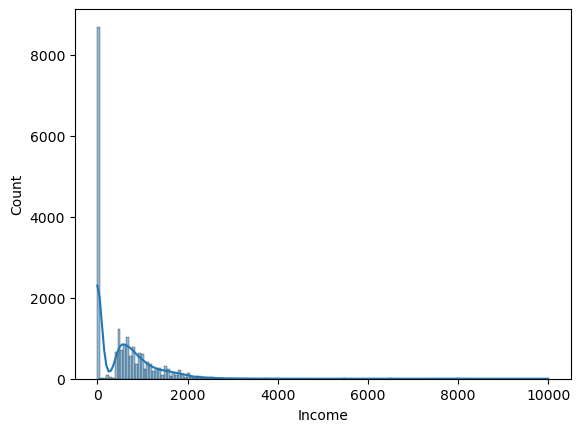

In [45]:
# Income 시각화
sns.histplot(train['Income'], kde=True)

In [46]:
# 이상치 처리 1
idx = train[(train['Income'] >= 5000) & (train['Income'] < 10000) & (train['Income_Status'] == 'Under Median')].index
train.drop(idx, axis=0, inplace=True)

In [48]:
# 이상치 처리 2
train.loc[(train['Gains'] == 99999), 'Gains'] = 0

In [49]:
# 이상치 처리 3
train[(train['Income'] > 7900)]
ov_idx = train[(train['Income'] > 7900)].index
train.drop(ov_idx, axis=0, inplace=True)

,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,Martial_Status,...,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income
ID,,,,,,,,,,,,,,,,,,,,,
TRAIN_02008,46,M,Doctorate degree,Children or Armed Forces,52,Other professional services,Professional,White,All other,Single,...,Native,US,US,US,Single,0,0,0,Over Median,9999
TRAIN_14222,19,M,Middle (7-8),Children or Armed Forces,34,Retail,Services,White,All other,Single,...,Native,US,US,US,Single,0,0,0,Unknown,8000
TRAIN_19030,60,F,High graduate,Full-Time,18,Entertainment,Services,White,All other,Widowed,...,Native,US,US,US,Single,0,0,1920,Unknown,9400


### 파생변수 생성
- 이민자 여부 (아버지를 중점으로)
- 투자와 관련된 값들이 이상치가 너무 높아 간단한 수학 공식을 적용해보았습니다.
$$df['Total Income indicator'] = \frac{df['Total Income indicator']}{||df['Tatal Income indicator']||_2}$$

In [52]:
# 파생변수 생성
def make_derived(df):
    
#     df['Gains'] = np.log1p(df['Gains'])
#     df['Losses'] = np.log1p(df['Losses'])
#     df['Dividends'] = np.log1p(df['Dividends'])
#     df['Industry_Occupation'] = df['Industry_Status'] + " - " + df['Occupation_Status']
    
    df['Immigrant_Background'] = np.where((df['Birth_Country'] == 'US') &
                                        (df['Birth_Country (Father)'] == 'US'), 'Native', 'Immigrant')
    
    df['Total Income indicator'] = (df['Gains'] - df['Losses'] + df['Dividends'])
    df['Total Income indicator'] = (df['Total Income indicator']) / np.sqrt(np.sum(df['Total Income indicator']**2))
    
    return df

make_derived(train)
make_derived(test)

,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,Martial_Status,...,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Immigrant_Background,Total Income indicator
ID,,,,,,,,,,,,,,,,,,,,,
TEST_0000,79,M,High Junior,Children or Armed Forces,0,Not in universe or children,Unknown,White,All other,Single,...,US,Unknown,Unknown,Single,0,0,0,Under Median,Immigrant,0.0
TEST_0001,47,M,Elementary (5-6),Children or Armed Forces,0,Not in universe or children,Unknown,White,Other Spanish,Single,...,US,US,US,Nonfiler,0,0,0,Under Median,Native,0.0
TEST_0002,18,F,High Junior,Children or Armed Forces,52,Retail,Services,White,All other,Single,...,US,US,US,Single,0,0,0,Under Median,Native,0.0
TEST_0003,39,F,Associates degree (Vocational),Full-Time,30,Medical (except Hospitals),Services,White,All other,Married,...,US,US,US,Married Filling Jointly both under 65 (MFJ),0,0,0,Unknown,Native,0.0
TEST_0004,6,M,Children,Children or Armed Forces,0,Not in universe or children,Unknown,White,Mexican-American,Single,...,US,US,US,Nonfiler,0,0,0,Unknown,Native,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TEST_9995,31,M,Bachelors degree,Children or Armed Forces,52,Other professional services,Technicians & Support,White,All other,Single,...,US,US,US,Single,0,0,0,Under Median,Native,0.0
TEST_9996,27,M,College,Children or Armed Forces,52,Retail,Handlers/Cleaners,White,All other,Married,...,US,US,US,Married Filling Jointly both under 65 (MFJ),0,0,0,Under Median,Native,0.0
TEST_9997,18,M,High graduate,Children or Armed Forces,7,Retail,Services,Black,All other,Single,...,US,US,US,Nonfiler,0,0,0,Under Median,Native,0.0


In [53]:
# columns drop
train = train.drop(['Losses', 
                    'Birth_Country (Father)', 'Birth_Country (Mother)'], axis=1)
test = test.drop(['Losses',
                  'Birth_Country (Father)', 'Birth_Country (Mother)'], axis=1)

In [54]:
# test값의 결측치 채우기
test['Household_Status'].fillna(test['Household_Status'].mode()[0], inplace=True)

In [57]:
# 라벨 인코딩
obj_cols = train.select_dtypes('object').columns.tolist()

for i in obj_cols:
    le = LabelEncoder()
    le = le.fit(train[i])
    train[i] = le.transform(train[i])
    test[i] = le.transform(test[i])

In [58]:
# index 초기화
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [60]:
# X와 y 데이터 분리 및 splits train and validation 
X = train.drop(['Income'], axis=1).copy()
y = train['Income'].copy()

X_tr, X_val, y_tr, y_val = train_test_split(X, y,
                                           test_size=0.3,
                                           random_state=42)

X_tr.shape, X_val.shape, y_tr.shape, y_val.shape

((13974, 20), (5989, 20), (13974,), (5989,))

In [61]:
# 모델 생성
cat = CatBoostRegressor(random_state=42,
                       verbose=500,
                       cat_features=[1, 2, 3, 5, 6, 7, 8 , 9, 10, 11, 12, 13, 14, 17, 18])

xgb = XGBRegressor(random_state=42,
                  n_jobs=-1)

lgb = LGBMRegressor(random_state=42,
                   n_jobs=-1)

hgb = HistGradientBoostingRegressor(random_state=42,
                                   categorical_features=[1, 2, 3, 5, 6, 7, 8 , 9, 10, 11, 12, 13, 14, 17, 18])

models = [cat, xgb, lgb, hgb]
scores_train = []
scores_of_r2_train = []
scores_of_r2_test = []
for idx, model in enumerate(models):
    model.fit(X_tr, y_tr)
    y_pred_train = model.predict(X_tr)
    y_pred_test = model.predict(X_val)
    
    train_r2 = r2_score(y_tr, y_pred_train)
    test_r2 = r2_score(y_val, y_pred_test)
    
    scores_of_r2_train.append(train_r2)
    scores_of_r2_test.append(test_r2)
    
    rmse = root_mean_squared_error(y_val, y_pred_test)
    scores_train.append(rmse)

Learning rate set to 0.062107
0:	learn: 616.6915763	total: 11.6ms	remaining: 11.6s
500:	learn: 470.0753246	total: 6.21s	remaining: 6.18s
999:	learn: 446.4673582	total: 12.7s	remaining: 0us


In [62]:
scores_train

[521.8406270135337, 546.7315444058573, 523.7265908517159, 523.8136108749181]

In [63]:
scores_of_r2_train

[0.4347266502913095,
 0.6763155050680278,
 0.5046585189457015,
 0.4787443972552584]

In [64]:
scores_of_r2_test

[0.35347305824915387,
 0.29032563759694996,
 0.3487914381170726,
 0.3485750164458492]

In [31]:
scores = cross_val_score(estimator=cat,
                        X=X, y=y,
                        scoring='neg_root_mean_squared_error',
                        cv=10,
                        n_jobs=-1)
-scores.mean()

513.6378671950822

In [73]:
def cat_objective(trial):
    param = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }
#     param = {
#         'loss_function': 'RMSE',
#         'task_type': 'GPU',
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
#         'max_bin': trial.suggest_int('max_bin', 200, 400),
#         'subsample': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
#         'learning_rate': trial.suggest_uniform('learning_rate', 0.006, 0.018),
#         'n_estimators':  1000,
#         'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15]),
#         'colsample_bylevel': trial.suggest_float("colsample_bylevel", 0.05, 1.0),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
#     }
    
    model = CatBoostRegressor(**param,
                            verbose=0,
                            cat_features=[1, 2, 3, 5, 6, 7, 8 , 9, 10, 11, 12, 13, 14, 17, 18])
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(cat_objective, n_trials=50)
print(f"Best hyperparameters: {study.best_params}")
print(f"Best RMSE: {study.best_value}")
cat_best_params = study.best_params

[I 2024-04-08 09:33:57,560] A new study created in memory with name: no-name-4a9e9d71-8121-466b-a75a-e6c4262e2769
[I 2024-04-08 09:34:01,411] Trial 0 finished with value: 556.6532513034022 and parameters: {'learning_rate': 0.0013482665773745053, 'depth': 3, 'subsample': 0.7125148704607959, 'colsample_bylevel': 0.7280138080430265, 'min_data_in_leaf': 36}. Best is trial 0 with value: 556.6532513034022.
[I 2024-04-08 09:34:02,494] Trial 1 finished with value: 563.8380034951887 and parameters: {'learning_rate': 0.0020866914513362586, 'depth': 1, 'subsample': 0.4732686468854842, 'colsample_bylevel': 0.3338596696790115, 'min_data_in_leaf': 97}. Best is trial 0 with value: 556.6532513034022.
[I 2024-04-08 09:34:03,479] Trial 2 finished with value: 551.3886117493512 and parameters: {'learning_rate': 0.004157997779172462, 'depth': 1, 'subsample': 0.37097587958143363, 'colsample_bylevel': 0.25408588668816223, 'min_data_in_leaf': 9}. Best is trial 2 with value: 551.3886117493512.
[I 2024-04-08 09

[I 2024-04-08 09:40:45,223] Trial 28 finished with value: 521.9417767971471 and parameters: {'learning_rate': 0.03102731921565127, 'depth': 9, 'subsample': 0.8713416887816167, 'colsample_bylevel': 0.644970515295714, 'min_data_in_leaf': 18}. Best is trial 27 with value: 521.2643174957802.
[I 2024-04-08 09:40:59,227] Trial 29 finished with value: 521.450070030189 and parameters: {'learning_rate': 0.04697063453621651, 'depth': 7, 'subsample': 0.7075336121552419, 'colsample_bylevel': 0.7578293962948665, 'min_data_in_leaf': 37}. Best is trial 27 with value: 521.2643174957802.
[I 2024-04-08 09:41:07,993] Trial 30 finished with value: 522.9539888057369 and parameters: {'learning_rate': 0.05119771633160953, 'depth': 5, 'subsample': 0.7364159169986182, 'colsample_bylevel': 0.7806900645367232, 'min_data_in_leaf': 40}. Best is trial 27 with value: 521.2643174957802.
[I 2024-04-08 09:41:22,296] Trial 31 finished with value: 521.646532166775 and parameters: {'learning_rate': 0.03506637523904851, 'd

Best hyperparameters: {'learning_rate': 0.02621011765978454, 'depth': 9, 'subsample': 0.5535156633171971, 'colsample_bylevel': 0.7743742347015513, 'min_data_in_leaf': 25}
Best RMSE: 521.1519316914816


In [71]:
def xgb_objective(trial):
    param = {
#         'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
#         'sampling_method': 'gradient_based',
#         'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
#         'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),
#         'eta': trial.suggest_categorical('eta', [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
#         'gamma': trial.suggest_categorical('gamma', [18, 19, 20, 21, 22, 23, 24, 25]),
#         'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
#         'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
#         'colsample_bynode': trial.suggest_categorical('colsample_bynode', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
#         'n_estimators': trial.suggest_int('n_estimators', 400, 1000),
#         'min_child_weight': trial.suggest_int('min_child_weight', 8, 600),  
#         'max_depth': trial.suggest_categorical('max_depth', [3, 4, 5, 6, 7]),  
#         'subsample': trial.suggest_categorical('subsample', [0.5,0.6,0.7,0.8,1.0]),
#         'random_state': 42
        'objective' : trial.suggest_categorical('objective',['reg:squarederror','reg:squaredlogerror','reg:pseudohubererror','reg:quantileerror']),
        'tree_method' :  trial.suggest_categorical('tree_method',['auto', 'exact', 'approx', 'hist']),
        'n_estimators' : trial.suggest_int('n_estimators', 300, 500),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 1.0),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'max_depth' : trial.suggest_int('max_depth', 5, 20),
        'max_leaves' : trial.suggest_int('max_leaves', 5, 20),
        'reg_alpha' : trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda' : trial.suggest_float('reg_lambda', 0.01, 1.0),
        'subsample' : trial.suggest_float('subsample', 0.01, 1.0),
        'gamma' : trial.suggest_float('gamma', 0.01, 1.0),
        'min_child_weight' : trial.suggest_float('min_child_weight', 1, 10),
        'colsample_bylevel' : trial.suggest_float('colsample_bylevel', 0.01, 1.0),
        'colsample_bynode' : trial.suggest_float('colsample_bynode', 0.01, 1.0),
        'quantile_alpha':trial.suggest_float('quantile_alpha', 0.01, 1.0) if trial.params['objective'] == 'reg:quantileerror' else None
    }
    
    model = XGBRegressor(**param,
                        n_jobs=-1)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    return rmse
study = optuna.create_study(direction='minimize')
study.optimize(xgb_objective, n_trials=200)
print(f"Best hyperparameters: {study.best_params}")
print(f"Best RMSE: {study.best_value}")
xgb_best_params = study.best_params

[I 2024-04-08 09:21:16,238] A new study created in memory with name: no-name-37d38604-14ba-409b-a2b4-57d3d653c234
[I 2024-04-08 09:21:16,455] Trial 0 finished with value: 553.447235508272 and parameters: {'objective': 'reg:squarederror', 'tree_method': 'approx', 'n_estimators': 305, 'learning_rate': 0.747254157190949, 'colsample_bytree': 0.8217699620915389, 'max_depth': 15, 'max_leaves': 15, 'reg_alpha': 0.021454036016571112, 'reg_lambda': 0.7765416042907257, 'subsample': 0.9818900562591096, 'gamma': 0.7109529294643611, 'min_child_weight': 3.5513774440406367, 'colsample_bylevel': 0.08911773755118217, 'colsample_bynode': 0.7493532753784731}. Best is trial 0 with value: 553.447235508272.
[I 2024-04-08 09:21:17,482] Trial 1 finished with value: 540.2887866913426 and parameters: {'objective': 'reg:pseudohubererror', 'tree_method': 'exact', 'n_estimators': 399, 'learning_rate': 0.622162226336311, 'colsample_bytree': 0.30935775254436004, 'max_depth': 19, 'max_leaves': 20, 'reg_alpha': 0.6271

[I 2024-04-08 09:21:26,985] Trial 14 finished with value: 1239.6011606602654 and parameters: {'objective': 'reg:pseudohubererror', 'tree_method': 'auto', 'n_estimators': 423, 'learning_rate': 0.959841376504436, 'colsample_bytree': 0.3526629596602603, 'max_depth': 13, 'max_leaves': 17, 'reg_alpha': 0.21518761265650388, 'reg_lambda': 0.016537786720461273, 'subsample': 0.5834116835018218, 'gamma': 0.5474405910080996, 'min_child_weight': 2.4132931005458373, 'colsample_bylevel': 0.6930873573385657, 'colsample_bynode': 0.625437963744583}. Best is trial 7 with value: 538.3966125477459.
[I 2024-04-08 09:21:27,463] Trial 15 finished with value: 666.7817962304199 and parameters: {'objective': 'reg:pseudohubererror', 'tree_method': 'exact', 'n_estimators': 329, 'learning_rate': 0.39663125327602256, 'colsample_bytree': 0.6802430135400563, 'max_depth': 7, 'max_leaves': 8, 'reg_alpha': 0.5100699481091717, 'reg_lambda': 0.2757129877259916, 'subsample': 0.23697658942127303, 'gamma': 0.1346700126429005

[I 2024-04-08 09:21:37,756] Trial 28 finished with value: 811.8329607184778 and parameters: {'objective': 'reg:squaredlogerror', 'tree_method': 'auto', 'n_estimators': 362, 'learning_rate': 0.20553359341068, 'colsample_bytree': 0.15619551779735816, 'max_depth': 14, 'max_leaves': 10, 'reg_alpha': 0.7106731435261551, 'reg_lambda': 0.363271096506255, 'subsample': 0.47648060906284184, 'gamma': 0.29336105865851386, 'min_child_weight': 5.957406191747461, 'colsample_bylevel': 0.7532839671826357, 'colsample_bynode': 0.11604897915866205}. Best is trial 7 with value: 538.3966125477459.
[I 2024-04-08 09:21:38,254] Trial 29 finished with value: 553.3532923088767 and parameters: {'objective': 'reg:squarederror', 'tree_method': 'approx', 'n_estimators': 320, 'learning_rate': 0.6692819995073468, 'colsample_bytree': 0.5513300729010807, 'max_depth': 11, 'max_leaves': 16, 'reg_alpha': 0.9232709165704828, 'reg_lambda': 0.6317209481380228, 'subsample': 0.9655702761517395, 'gamma': 0.6049909123406868, 'min

[I 2024-04-08 09:21:45,870] Trial 43 finished with value: 534.1257036732252 and parameters: {'objective': 'reg:squarederror', 'tree_method': 'hist', 'n_estimators': 375, 'learning_rate': 0.08630543047104627, 'colsample_bytree': 0.22231371542187273, 'max_depth': 8, 'max_leaves': 14, 'reg_alpha': 0.7457452489767609, 'reg_lambda': 0.20143489486980326, 'subsample': 0.654463994127719, 'gamma': 0.8505872184594993, 'min_child_weight': 9.49603520139877, 'colsample_bylevel': 0.5754010439429419, 'colsample_bynode': 0.08569862312562364}. Best is trial 38 with value: 531.7070332418538.
[I 2024-04-08 09:21:46,329] Trial 44 finished with value: 532.4532062956295 and parameters: {'objective': 'reg:squarederror', 'tree_method': 'hist', 'n_estimators': 375, 'learning_rate': 0.10412776605959978, 'colsample_bytree': 0.23646572905902474, 'max_depth': 8, 'max_leaves': 14, 'reg_alpha': 0.757747859810748, 'reg_lambda': 0.2009928686131114, 'subsample': 0.6675402757791762, 'gamma': 0.8643456136291309, 'min_chi

[I 2024-04-08 09:21:53,755] Trial 58 finished with value: 540.6343177360602 and parameters: {'objective': 'reg:squarederror', 'tree_method': 'hist', 'n_estimators': 384, 'learning_rate': 0.05999764276178346, 'colsample_bytree': 0.5194179523968492, 'max_depth': 10, 'max_leaves': 9, 'reg_alpha': 0.0175075977009434, 'reg_lambda': 0.31235874057090673, 'subsample': 0.5886947228751768, 'gamma': 0.6363584357012585, 'min_child_weight': 9.09852771163388, 'colsample_bylevel': 0.36329252081963986, 'colsample_bynode': 0.18925220047110836}. Best is trial 48 with value: 531.5601217721847.
[I 2024-04-08 09:21:54,240] Trial 59 finished with value: 532.5009716742784 and parameters: {'objective': 'reg:squarederror', 'tree_method': 'hist', 'n_estimators': 432, 'learning_rate': 0.12117040874466595, 'colsample_bytree': 0.4348083728822093, 'max_depth': 12, 'max_leaves': 13, 'reg_alpha': 0.7679554930441381, 'reg_lambda': 0.5169883695216008, 'subsample': 0.559853805358565, 'gamma': 0.7651349317784408, 'min_ch

[I 2024-04-08 09:22:03,132] Trial 73 finished with value: 528.8873238294574 and parameters: {'objective': 'reg:squarederror', 'tree_method': 'hist', 'n_estimators': 407, 'learning_rate': 0.05350712925052926, 'colsample_bytree': 0.3470748368847921, 'max_depth': 7, 'max_leaves': 15, 'reg_alpha': 0.06377584088598114, 'reg_lambda': 0.5791881723477666, 'subsample': 0.7613640171027313, 'gamma': 0.7261235018490666, 'min_child_weight': 9.166211438784721, 'colsample_bylevel': 0.5283859773386357, 'colsample_bynode': 0.9847772439855201}. Best is trial 64 with value: 528.5879276310973.
[I 2024-04-08 09:22:03,728] Trial 74 finished with value: 537.6600476427008 and parameters: {'objective': 'reg:squarederror', 'tree_method': 'hist', 'n_estimators': 405, 'learning_rate': 0.04969861164386746, 'colsample_bytree': 0.34214280484365783, 'max_depth': 7, 'max_leaves': 15, 'reg_alpha': 0.08109120851741741, 'reg_lambda': 0.5878111105631643, 'subsample': 0.8614414050876602, 'gamma': 0.7319100540384361, 'min_c

[I 2024-04-08 09:22:27,425] Trial 88 finished with value: 529.0048480927475 and parameters: {'objective': 'reg:squarederror', 'tree_method': 'exact', 'n_estimators': 486, 'learning_rate': 0.010187380708894377, 'colsample_bytree': 0.8084528854792377, 'max_depth': 5, 'max_leaves': 17, 'reg_alpha': 0.014507857795695966, 'reg_lambda': 0.5477847252587522, 'subsample': 0.9447734356369701, 'gamma': 0.49166081694463376, 'min_child_weight': 4.661230972301319, 'colsample_bylevel': 0.5649082449190044, 'colsample_bynode': 0.9285655851509598}. Best is trial 78 with value: 526.7499026412567.
[I 2024-04-08 09:22:29,230] Trial 89 finished with value: 529.2120985133054 and parameters: {'objective': 'reg:squarederror', 'tree_method': 'exact', 'n_estimators': 484, 'learning_rate': 0.01033834336346574, 'colsample_bytree': 0.8088404642697439, 'max_depth': 5, 'max_leaves': 18, 'reg_alpha': 0.013950428393051613, 'reg_lambda': 0.5382099491827527, 'subsample': 0.953436378766805, 'gamma': 0.4894450527692545, 'm

[I 2024-04-08 09:22:59,363] Trial 103 finished with value: 526.272847006654 and parameters: {'objective': 'reg:squarederror', 'tree_method': 'exact', 'n_estimators': 453, 'learning_rate': 0.031150760934386557, 'colsample_bytree': 0.8894639642512375, 'max_depth': 5, 'max_leaves': 16, 'reg_alpha': 0.2593138873957625, 'reg_lambda': 0.8458335923052633, 'subsample': 0.8479980018543989, 'gamma': 0.5700961449209102, 'min_child_weight': 5.4814317177531855, 'colsample_bylevel': 0.6409836091117623, 'colsample_bynode': 0.8667467904327625}. Best is trial 103 with value: 526.272847006654.
[I 2024-04-08 09:23:02,060] Trial 104 finished with value: 592.8335302590148 and parameters: {'objective': 'reg:squarederror', 'tree_method': 'exact', 'n_estimators': 467, 'learning_rate': 0.5487195365743838, 'colsample_bytree': 0.8955807556445011, 'max_depth': 5, 'max_leaves': 17, 'reg_alpha': 0.14561074557616308, 'reg_lambda': 0.9244355693026041, 'subsample': 0.9112845481899945, 'gamma': 0.5701017229463922, 'min

[I 2024-04-08 09:23:37,617] Trial 117 finished with value: 530.8860886323179 and parameters: {'objective': 'reg:squarederror', 'tree_method': 'exact', 'n_estimators': 496, 'learning_rate': 0.057070634209021434, 'colsample_bytree': 0.933797310333377, 'max_depth': 6, 'max_leaves': 17, 'reg_alpha': 0.3124388586156977, 'reg_lambda': 0.8568559327450704, 'subsample': 0.7956387402968732, 'gamma': 0.3932530651581501, 'min_child_weight': 4.658160117695569, 'colsample_bylevel': 0.7092402456660594, 'colsample_bynode': 0.9598329941450668}. Best is trial 110 with value: 525.5619151451632.
[I 2024-04-08 09:23:39,675] Trial 118 finished with value: 550.4861745727237 and parameters: {'objective': 'reg:pseudohubererror', 'tree_method': 'exact', 'n_estimators': 495, 'learning_rate': 0.024905038340154596, 'colsample_bytree': 0.950265870872075, 'max_depth': 5, 'max_leaves': 19, 'reg_alpha': 0.418209543127047, 'reg_lambda': 0.910419955428213, 'subsample': 0.8314191296419943, 'gamma': 0.6174960212776915, 'm

[I 2024-04-08 09:24:23,312] Trial 132 finished with value: 527.3005537932215 and parameters: {'objective': 'reg:squarederror', 'tree_method': 'exact', 'n_estimators': 470, 'learning_rate': 0.05048198170308271, 'colsample_bytree': 0.8919338179353122, 'max_depth': 5, 'max_leaves': 16, 'reg_alpha': 0.2899784635595051, 'reg_lambda': 0.9804537308014853, 'subsample': 0.7849834256907854, 'gamma': 0.5928368292530025, 'min_child_weight': 5.83963589262489, 'colsample_bylevel': 0.8670116976100694, 'colsample_bynode': 0.962277373049024}. Best is trial 110 with value: 525.5619151451632.
[I 2024-04-08 09:24:25,868] Trial 133 finished with value: 525.6397428474891 and parameters: {'objective': 'reg:squarederror', 'tree_method': 'exact', 'n_estimators': 478, 'learning_rate': 0.02298707507313398, 'colsample_bytree': 0.9524494420617915, 'max_depth': 5, 'max_leaves': 16, 'reg_alpha': 0.4901264418357822, 'reg_lambda': 0.9608923976802954, 'subsample': 0.836419960727572, 'gamma': 0.6289914130226132, 'min_ch

0:	learn: 637.7921411	total: 71.1ms	remaining: 1m 10s
500:	learn: 496.7397401	total: 43.5s	remaining: 43.3s
999:	learn: 480.4669142	total: 1m 31s	remaining: 0us
0:	learn: 627.8896617	total: 120ms	remaining: 1m 59s
500:	learn: 487.0940528	total: 42.7s	remaining: 42.5s
999:	learn: 469.9452734	total: 1m 39s	remaining: 0us
0:	learn: 628.6111796	total: 81.4ms	remaining: 1m 21s
500:	learn: 488.7336508	total: 42.6s	remaining: 42.4s
999:	learn: 472.3589610	total: 1m 30s	remaining: 0us
0:	learn: 635.5310888	total: 179ms	remaining: 2m 58s
500:	learn: 494.5522046	total: 42.9s	remaining: 42.7s
999:	learn: 478.8782440	total: 1m 39s	remaining: 0us
0:	learn: 630.0729123	total: 135ms	remaining: 2m 15s
500:	learn: 490.3933213	total: 43.8s	remaining: 43.6s
999:	learn: 474.2624575	total: 1m 31s	remaining: 0us
0:	learn: 634.3319020	total: 44.3ms	remaining: 44.2s
500:	learn: 498.2142717	total: 10.5s	remaining: 10.5s
999:	learn: 483.2479663	total: 22.9s	remaining: 0us
0:	learn: 626.3547567	total: 111ms	rema

[I 2024-04-08 09:24:44,455] Trial 138 finished with value: 843.7005686821935 and parameters: {'objective': 'reg:quantileerror', 'tree_method': 'exact', 'n_estimators': 478, 'learning_rate': 0.37717273217042624, 'colsample_bytree': 0.9579683226222571, 'max_depth': 6, 'max_leaves': 16, 'reg_alpha': 0.4332411295766374, 'reg_lambda': 0.9601463295616062, 'subsample': 0.8330031376831174, 'gamma': 0.6648145278012261, 'min_child_weight': 5.660785336588814, 'colsample_bylevel': 0.9018182367808238, 'colsample_bynode': 0.9491048749387025, 'quantile_alpha': 0.26766052971211574}. Best is trial 135 with value: 525.2635661119577.
[I 2024-04-08 09:24:45,141] Trial 139 finished with value: 525.9041626555659 and parameters: {'objective': 'reg:squarederror', 'tree_method': 'auto', 'n_estimators': 461, 'learning_rate': 0.024056301484700428, 'colsample_bytree': 0.989519423761204, 'max_depth': 6, 'max_leaves': 17, 'reg_alpha': 0.3912396232220644, 'reg_lambda': 0.9330550894156735, 'subsample': 0.863290102343

[I 2024-04-08 09:24:53,457] Trial 153 finished with value: 530.0421111254077 and parameters: {'objective': 'reg:squarederror', 'tree_method': 'auto', 'n_estimators': 474, 'learning_rate': 0.06901101340655544, 'colsample_bytree': 0.9473027874544733, 'max_depth': 20, 'max_leaves': 16, 'reg_alpha': 0.3568870155545757, 'reg_lambda': 0.9673602466056488, 'subsample': 0.8307481108275312, 'gamma': 0.5518515224226055, 'min_child_weight': 5.832768961764986, 'colsample_bylevel': 0.9750978532256651, 'colsample_bynode': 0.8973076242848795}. Best is trial 135 with value: 525.2635661119577.
[I 2024-04-08 09:24:54,208] Trial 154 finished with value: 534.2283359075582 and parameters: {'objective': 'reg:squarederror', 'tree_method': 'auto', 'n_estimators': 478, 'learning_rate': 0.025231076299196842, 'colsample_bytree': 0.9254044060250801, 'max_depth': 5, 'max_leaves': 16, 'reg_alpha': 0.2918204424701531, 'reg_lambda': 0.9404785323299845, 'subsample': 0.029177152465634404, 'gamma': 0.5739813363280942, 'm

0:	learn: 639.6287239	total: 101ms	remaining: 1m 40s
500:	learn: 500.4093377	total: 44.3s	remaining: 44.2s
999:	learn: 483.7736855	total: 1m 31s	remaining: 0us
0:	learn: 634.1344255	total: 142ms	remaining: 2m 21s
500:	learn: 493.9125370	total: 41.5s	remaining: 41.4s
999:	learn: 477.6910553	total: 1m 37s	remaining: 0us
0:	learn: 630.2094730	total: 96.8ms	remaining: 1m 36s
500:	learn: 490.4801174	total: 11.4s	remaining: 11.4s
999:	learn: 474.4042020	total: 22.9s	remaining: 0us
0:	learn: 631.8386067	total: 76.2ms	remaining: 1m 16s
500:	learn: 493.8245612	total: 43.9s	remaining: 43.7s
999:	learn: 478.8139284	total: 1m 31s	remaining: 0us
0:	learn: 633.7877046	total: 58.6ms	remaining: 58.5s
500:	learn: 490.4439598	total: 42.1s	remaining: 42s
999:	learn: 474.5462281	total: 1m 38s	remaining: 0us
0:	learn: 628.3323421	total: 52.2ms	remaining: 52.2s
500:	learn: 487.2305296	total: 11.2s	remaining: 11.1s
999:	learn: 471.8595201	total: 22.5s	remaining: 0us


[I 2024-04-08 09:25:05,679] Trial 164 finished with value: 525.85482261367 and parameters: {'objective': 'reg:squarederror', 'tree_method': 'exact', 'n_estimators': 490, 'learning_rate': 0.010484854985334437, 'colsample_bytree': 0.9442939194556947, 'max_depth': 6, 'max_leaves': 16, 'reg_alpha': 0.3122192952296494, 'reg_lambda': 0.9596311253993435, 'subsample': 0.8687254821213664, 'gamma': 0.6390423221751704, 'min_child_weight': 5.673615545187704, 'colsample_bylevel': 0.8290469690419163, 'colsample_bynode': 0.9828055511108548}. Best is trial 135 with value: 525.2635661119577.
[I 2024-04-08 09:25:09,149] Trial 165 finished with value: 528.1775953627894 and parameters: {'objective': 'reg:squarederror', 'tree_method': 'exact', 'n_estimators': 489, 'learning_rate': 0.0444285927464703, 'colsample_bytree': 0.9386201272516789, 'max_depth': 6, 'max_leaves': 17, 'reg_alpha': 0.2769333737319639, 'reg_lambda': 0.8577969142287011, 'subsample': 0.8788938837525382, 'gamma': 0.6408735108114848, 'min_c

[I 2024-04-08 09:25:55,485] Trial 179 finished with value: 530.0568818345226 and parameters: {'objective': 'reg:squarederror', 'tree_method': 'exact', 'n_estimators': 462, 'learning_rate': 0.06804343607724239, 'colsample_bytree': 0.9139067376814419, 'max_depth': 5, 'max_leaves': 16, 'reg_alpha': 0.25036751868458784, 'reg_lambda': 0.9732909330774463, 'subsample': 0.8552609490286988, 'gamma': 0.38824884382678687, 'min_child_weight': 6.011623242048916, 'colsample_bylevel': 0.7714607579382414, 'colsample_bynode': 0.9998941264605233}. Best is trial 135 with value: 525.2635661119577.
[I 2024-04-08 09:25:56,751] Trial 180 finished with value: 691.8965090188132 and parameters: {'objective': 'reg:pseudohubererror', 'tree_method': 'exact', 'n_estimators': 484, 'learning_rate': 0.011215022068155106, 'colsample_bytree': 0.9789897741258938, 'max_depth': 13, 'max_leaves': 15, 'reg_alpha': 0.42126630451312347, 'reg_lambda': 0.913282595250507, 'subsample': 0.7753399712595463, 'gamma': 0.54184265061188

[I 2024-04-08 09:26:31,267] Trial 194 finished with value: 525.7125521412387 and parameters: {'objective': 'reg:squarederror', 'tree_method': 'exact', 'n_estimators': 466, 'learning_rate': 0.011149743870183583, 'colsample_bytree': 0.9500653712942217, 'max_depth': 6, 'max_leaves': 14, 'reg_alpha': 0.39073880039787595, 'reg_lambda': 0.9482730795815311, 'subsample': 0.8711768429750826, 'gamma': 0.6656748184900938, 'min_child_weight': 4.581125993776513, 'colsample_bylevel': 0.9976955636841355, 'colsample_bynode': 0.9810069352921503}. Best is trial 189 with value: 524.86363665548.
[I 2024-04-08 09:26:34,599] Trial 195 finished with value: 525.7679457689753 and parameters: {'objective': 'reg:squarederror', 'tree_method': 'exact', 'n_estimators': 467, 'learning_rate': 0.011275426035846414, 'colsample_bytree': 0.9488868544104663, 'max_depth': 6, 'max_leaves': 15, 'reg_alpha': 0.41419916472054724, 'reg_lambda': 0.9512682731591432, 'subsample': 0.8713514866478592, 'gamma': 0.6787626378014116, 'm

Best hyperparameters: {'objective': 'reg:squarederror', 'tree_method': 'exact', 'n_estimators': 469, 'learning_rate': 0.010828519269792298, 'colsample_bytree': 0.8995344446458294, 'max_depth': 7, 'max_leaves': 14, 'reg_alpha': 0.3296000533693596, 'reg_lambda': 0.9985657278585574, 'subsample': 0.8880381991184233, 'gamma': 0.6477374799167938, 'min_child_weight': 5.245177086506111, 'colsample_bylevel': 0.8193715308608529, 'colsample_bynode': 0.9396813026994945}
Best RMSE: 524.86363665548


In [72]:
def hgb_objective(trial):
    param = {
        'loss':trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'poisson', 'quantile']),
        'quantile' : trial.suggest_float('quantile', 0.01, 0.1),
        'max_iter':trial.suggest_int('max_iter', 10, 500),
        'learning_rate':trial.suggest_float('learning_rate', 0.01, 0.1),
        'l2_regularization' : trial.suggest_float('l2_regularization', 0.01, 0.1),
        'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 5, 50),
        'min_samples_leaf':trial.suggest_int('min_samples_leaf', 5, 50),
        'max_depth':trial.suggest_int('max_depth', 2, 12),
    }
    
    model = HistGradientBoostingRegressor(**param,
                                         categorical_features=[1, 2, 3, 5, 6, 7, 8 , 9, 10, 11, 12, 13, 14, 17, 18])
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    return rmse
study = optuna.create_study(direction='minimize')
study.optimize(hgb_objective, n_trials=150)
print(f"Best hyperparameters: {study.best_params}")
print(f"Best RMSE: {study.best_value}")
hgb_best_params = study.best_params

[I 2024-04-08 09:26:50,165] A new study created in memory with name: no-name-d3a02ed8-2795-40fd-a9ee-855a7b77b720
[I 2024-04-08 09:26:50,762] Trial 0 finished with value: 521.8997429654592 and parameters: {'loss': 'poisson', 'quantile': 0.09547946239269785, 'max_iter': 239, 'learning_rate': 0.09123830993542811, 'l2_regularization': 0.08508682012029345, 'max_leaf_nodes': 6, 'min_samples_leaf': 24, 'max_depth': 9}. Best is trial 0 with value: 521.8997429654592.
[I 2024-04-08 09:26:54,037] Trial 1 finished with value: 522.5141841621421 and parameters: {'loss': 'poisson', 'quantile': 0.06512936240602739, 'max_iter': 393, 'learning_rate': 0.0254346199387095, 'l2_regularization': 0.03541791540830104, 'max_leaf_nodes': 40, 'min_samples_leaf': 45, 'max_depth': 10}. Best is trial 0 with value: 521.8997429654592.
[I 2024-04-08 09:26:54,791] Trial 2 finished with value: 521.7585727795272 and parameters: {'loss': 'squared_error', 'quantile': 0.07682644921349975, 'max_iter': 137, 'learning_rate': 0

[I 2024-04-08 09:27:08,224] Trial 23 finished with value: 522.744676974407 and parameters: {'loss': 'squared_error', 'quantile': 0.04166387669783999, 'max_iter': 303, 'learning_rate': 0.07766429354282817, 'l2_regularization': 0.04333694251318919, 'max_leaf_nodes': 19, 'min_samples_leaf': 5, 'max_depth': 8}. Best is trial 11 with value: 521.1653383119773.
[I 2024-04-08 09:27:09,043] Trial 24 finished with value: 520.7999135741652 and parameters: {'loss': 'squared_error', 'quantile': 0.05643920735170049, 'max_iter': 438, 'learning_rate': 0.07391742539286848, 'l2_regularization': 0.07970143748517519, 'max_leaf_nodes': 26, 'min_samples_leaf': 12, 'max_depth': 4}. Best is trial 24 with value: 520.7999135741652.
[I 2024-04-08 09:27:10,030] Trial 25 finished with value: 523.2979618436383 and parameters: {'loss': 'squared_error', 'quantile': 0.05460773027720873, 'max_iter': 429, 'learning_rate': 0.03666020962979148, 'l2_regularization': 0.08093622880615403, 'max_leaf_nodes': 34, 'min_samples_l

[I 2024-04-08 09:27:37,205] Trial 47 finished with value: 520.6372072595426 and parameters: {'loss': 'poisson', 'quantile': 0.08984462545365551, 'max_iter': 362, 'learning_rate': 0.03117321150458558, 'l2_regularization': 0.0727948302369876, 'max_leaf_nodes': 19, 'min_samples_leaf': 18, 'max_depth': 8}. Best is trial 47 with value: 520.6372072595426.
[I 2024-04-08 09:27:39,505] Trial 48 finished with value: 522.2644976598084 and parameters: {'loss': 'poisson', 'quantile': 0.07838883095283077, 'max_iter': 287, 'learning_rate': 0.0292667169923019, 'l2_regularization': 0.06659819602556043, 'max_leaf_nodes': 48, 'min_samples_leaf': 32, 'max_depth': 8}. Best is trial 47 with value: 520.6372072595426.
[I 2024-04-08 09:27:43,155] Trial 49 finished with value: 520.862584910846 and parameters: {'loss': 'poisson', 'quantile': 0.08955411144286356, 'max_iter': 399, 'learning_rate': 0.018117029202812086, 'l2_regularization': 0.07822537042258004, 'max_leaf_nodes': 23, 'min_samples_leaf': 20, 'max_dep

[I 2024-04-08 09:29:03,954] Trial 71 finished with value: 520.5009339974899 and parameters: {'loss': 'poisson', 'quantile': 0.09924381188753169, 'max_iter': 462, 'learning_rate': 0.01974995845542434, 'l2_regularization': 0.09390439221115293, 'max_leaf_nodes': 35, 'min_samples_leaf': 45, 'max_depth': 10}. Best is trial 62 with value: 519.2947262865175.
[I 2024-04-08 09:29:07,400] Trial 72 finished with value: 521.7162704368889 and parameters: {'loss': 'poisson', 'quantile': 0.0922390512581509, 'max_iter': 422, 'learning_rate': 0.018491934265632417, 'l2_regularization': 0.09011805617295321, 'max_leaf_nodes': 31, 'min_samples_leaf': 50, 'max_depth': 10}. Best is trial 62 with value: 519.2947262865175.
[I 2024-04-08 09:29:10,147] Trial 73 finished with value: 521.6863819119732 and parameters: {'loss': 'poisson', 'quantile': 0.09717856472838371, 'max_iter': 412, 'learning_rate': 0.027256820788385833, 'l2_regularization': 0.08652863400396199, 'max_leaf_nodes': 35, 'min_samples_leaf': 42, 'ma

[I 2024-04-08 09:30:30,407] Trial 95 finished with value: 521.509497134005 and parameters: {'loss': 'poisson', 'quantile': 0.09993378937547691, 'max_iter': 430, 'learning_rate': 0.01795632457211603, 'l2_regularization': 0.09973958667669484, 'max_leaf_nodes': 26, 'min_samples_leaf': 47, 'max_depth': 11}. Best is trial 62 with value: 519.2947262865175.
[I 2024-04-08 09:30:34,642] Trial 96 finished with value: 520.7613981617787 and parameters: {'loss': 'poisson', 'quantile': 0.08488711371241527, 'max_iter': 391, 'learning_rate': 0.011813812619118973, 'l2_regularization': 0.08954095045192281, 'max_leaf_nodes': 28, 'min_samples_leaf': 44, 'max_depth': 12}. Best is trial 62 with value: 519.2947262865175.
[I 2024-04-08 09:30:38,447] Trial 97 finished with value: 520.933358593134 and parameters: {'loss': 'poisson', 'quantile': 0.08836082993825767, 'max_iter': 489, 'learning_rate': 0.01568788506561074, 'l2_regularization': 0.08179944203972923, 'max_leaf_nodes': 30, 'min_samples_leaf': 46, 'max_

[I 2024-04-08 09:31:59,701] Trial 119 finished with value: 521.0230246451308 and parameters: {'loss': 'poisson', 'quantile': 0.09565295522982864, 'max_iter': 462, 'learning_rate': 0.011328823282801388, 'l2_regularization': 0.08904890985326025, 'max_leaf_nodes': 20, 'min_samples_leaf': 45, 'max_depth': 9}. Best is trial 62 with value: 519.2947262865175.
[I 2024-04-08 09:32:02,271] Trial 120 finished with value: 522.0132035296502 and parameters: {'loss': 'poisson', 'quantile': 0.08573849744049654, 'max_iter': 474, 'learning_rate': 0.02264996955496327, 'l2_regularization': 0.09194904585229513, 'max_leaf_nodes': 25, 'min_samples_leaf': 47, 'max_depth': 10}. Best is trial 62 with value: 519.2947262865175.
[I 2024-04-08 09:32:06,233] Trial 121 finished with value: 523.0562203333561 and parameters: {'loss': 'poisson', 'quantile': 0.09699621357389626, 'max_iter': 444, 'learning_rate': 0.020420801664260982, 'l2_regularization': 0.08989115105341182, 'max_leaf_nodes': 35, 'min_samples_leaf': 17, 

[I 2024-04-08 09:33:38,588] Trial 143 finished with value: 521.3921641272966 and parameters: {'loss': 'poisson', 'quantile': 0.08501999414718014, 'max_iter': 492, 'learning_rate': 0.010189067580183928, 'l2_regularization': 0.0633756507921646, 'max_leaf_nodes': 22, 'min_samples_leaf': 16, 'max_depth': 7}. Best is trial 62 with value: 519.2947262865175.
[I 2024-04-08 09:33:41,808] Trial 144 finished with value: 519.9571168692363 and parameters: {'loss': 'poisson', 'quantile': 0.09422318440842718, 'max_iter': 483, 'learning_rate': 0.013037826188430171, 'l2_regularization': 0.06671115339484109, 'max_leaf_nodes': 20, 'min_samples_leaf': 38, 'max_depth': 12}. Best is trial 62 with value: 519.2947262865175.
[I 2024-04-08 09:33:45,844] Trial 145 finished with value: 519.1879838348441 and parameters: {'loss': 'poisson', 'quantile': 0.08759098867222093, 'max_iter': 482, 'learning_rate': 0.012574724351851313, 'l2_regularization': 0.06345563442086194, 'max_leaf_nodes': 19, 'min_samples_leaf': 38, 

Best hyperparameters: {'loss': 'poisson', 'quantile': 0.08759098867222093, 'max_iter': 482, 'learning_rate': 0.012574724351851313, 'l2_regularization': 0.06345563442086194, 'max_leaf_nodes': 19, 'min_samples_leaf': 38, 'max_depth': 12}
Best RMSE: 519.1879838348441


In [76]:
# xgb_params = {'learning_rate': 0.016838742164370216, 
#               'subsample': 0.8666720048612185, 
#               'colsample_bytree': 0.18688459705364951, 
#               'gamma': 20, 'n_estimators': 641, 
#               'min_child_weight': 0.3509849473293521}

# hgb_params = {'max_leaf_nodes': 19, 
#               'learning_rate': 0.049120475865009075, 
#               'max_depth': 18, 
#               'min_samples_leaf': 38}

xgb_model = XGBRegressor(**xgb_best_params)
cat_model = CatBoostRegressor(**cat_best_params,
                              verbose=200,
                             cat_features=[1, 2, 3, 5, 6, 7, 8 , 9, 10, 11, 12, 13, 14, 17, 18])
hgb_model = HistGradientBoostingRegressor(**hgb_best_params,
                                         categorical_features=[1, 2, 3, 5, 6, 7, 8 , 9, 10, 11, 12, 13, 14, 17, 18])

voting_regressor = VotingRegressor(estimators=[('catboost', cat_model),
                                  ('xgb', xgb_model),
                                  ('hgb', hgb_model)])

model = voting_regressor.fit(X_tr, y_tr)

0:	learn: 623.0672405	total: 18.4ms	remaining: 18.4s
200:	learn: 485.1055437	total: 5.2s	remaining: 20.7s
400:	learn: 468.3065915	total: 10.9s	remaining: 16.4s
600:	learn: 452.6217918	total: 16.8s	remaining: 11.1s
800:	learn: 439.5916260	total: 22.5s	remaining: 5.58s
999:	learn: 427.7634913	total: 28.1s	remaining: 0us


In [77]:
scores = cross_val_score(estimator=model,
                        X=X, y=y,
                        scoring='neg_root_mean_squared_error',
                        cv=10,
                        n_jobs=-1)

-scores.mean()

506.59485377399585

In [79]:
test.drop('Income', axis=1, inplace=True)
pred = model.predict(test)
pred = [0 if i < 0 else i for i in pred]

In [80]:
test['Income'] = pred
test.loc[test['Age'] == 0, 'Income'] = 0
y_result = test['Income'].values

Text(0.5, 1.0, '0406')

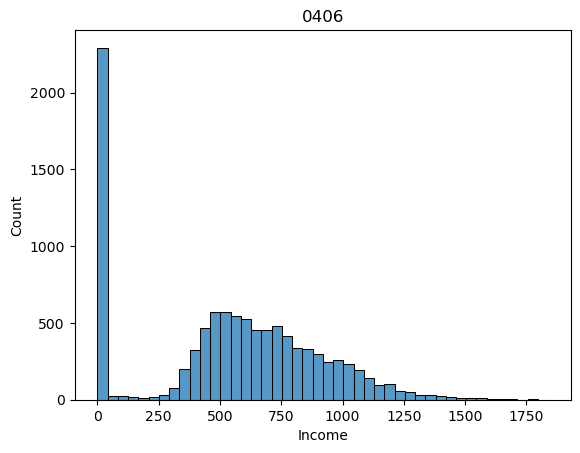

In [82]:
sub['Income'] = y_result
sub.to_csv('data/sub_0408_3.csv', index=False)
df_sub = pd.read_csv('data/sub_0408_3.csv')
sns.histplot(df_sub['Income'])
plt.title("0406")